<a href="https://colab.research.google.com/github/Julia891021/954/blob/main/hairstyle_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install efficientnet_pytorch
!pip install torchvision
!pip install ipywidgets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import pandas as pd
import os
from PIL import Image
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split

import numpy as np
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F
from efficientnet_pytorch import EfficientNet

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### 串接雲端硬碟

In [6]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/Shareddrives/954')

Mounted at /content/drive


### Import Library

In [7]:
# Check data directory
os.listdir("HairStyle Dataset")

['LongStraightFlat',
 'ShortCurlyOblique',
 'LongStraightOblique',
 'ShortStraightOblique',
 'ShortStraightFlat',
 'ShortCurlyFlat',
 'LongCurlyFlat',
 'LongCurlyOblique']

### Split train, val 

In [8]:
def split_train_val(data_dir, val_size=0.1, random_state=42):
    data=[]
    for dset in os.listdir(data_dir):  #dset:8種髮型
        # check is directory
        imgdir = os.path.join(data_dir, dset)
        if os.path.isdir(imgdir):
            for image_path in os.listdir(imgdir):
                if image_path.endswith(".jpeg"):
                    sample = {
                        "path": os.path.join(data_dir, dset, image_path),
                        "label": dset
                    }
                    data.append(sample)
    train, test = train_test_split(data, test_size=0.2, random_state=random_state)
    train = pd.DataFrame(train)
    test = pd.DataFrame(test)
    train, val = train_test_split(train, test_size=val_size, random_state=random_state)
    # save to csv
#     train_path, val_path, test_path = os.path.join(data_dir, "train.csv"), os.path.join(data_dir, "val.csv"), os.path.join(data_dir, "test.csv")
#     train.to_csv(train_path, index=False)
#     val.to_csv(val_path, index=False)
#     test.to_csv(test_path, index=False)
    
    return train, val, test

train_df, val_df, test_df = split_train_val("HairStyle Dataset")
test_df

,path,label
0,HairStyle Dataset/ShortStraightOblique/Square1...,ShortStraightOblique
1,HairStyle Dataset/ShortCurlyOblique/Round141.jpeg,ShortCurlyOblique
2,HairStyle Dataset/LongCurlyOblique/Square53.jpeg,LongCurlyOblique
3,HairStyle Dataset/LongCurlyOblique/Oblong160.jpeg,LongCurlyOblique
4,HairStyle Dataset/LongStraightOblique/Oval103....,LongStraightOblique
...,...,...
790,HairStyle Dataset/ShortStraightOblique/Oval294...,ShortStraightOblique
791,HairStyle Dataset/LongCurlyOblique/Oblong72.jpeg,LongCurlyOblique
792,HairStyle Dataset/ShortCurlyOblique/Round127.jpeg,ShortCurlyOblique
793,HairStyle Dataset/LongStraightOblique/Oval51.jpeg,LongStraightOblique


### Visualize some images and labels

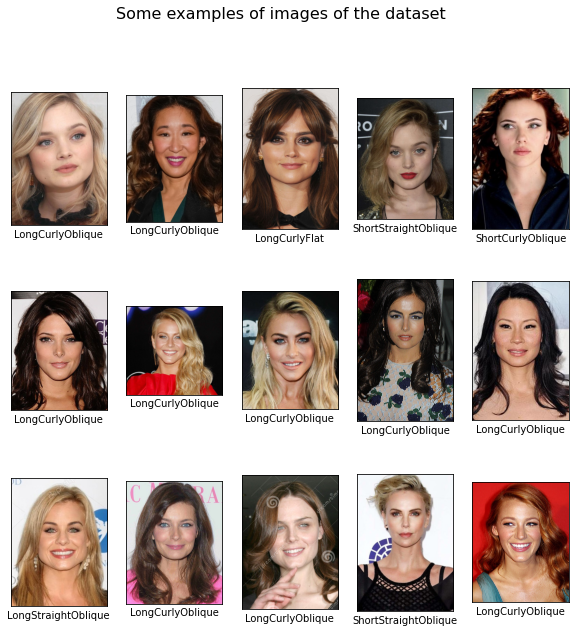

In [9]:
import cv2
import matplotlib.pyplot as plt  

def display_examples():
    
    """
        Display 15 images from the images and labels
    """
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(15):
        plt.subplot(3,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        img_path = train_df.iloc[i]["path"]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        plt.imshow(image, cmap=plt.cm.binary)
        plt.xlabel(train_df.iloc[i]["label"])
    plt.show()

display_examples()


### Dataset

In [10]:
# Dataset
class HairStyleDataset(torch.utils.data.Dataset):
    def __init__(self, df, transform=None, split="train"):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.split = split
        class_names = ['LongCurlyOblique','LongStraightFlat','LongStraightOblique','ShortStraightFlat','ShortStraightOblique','ShortCurlyFlat','ShortCurlyOblique','LongCurlyFlat']
        self.label2idx = {class_name:i for i, class_name in enumerate(class_names)}
        self.idx2label = {v:k for k,v in self.label2idx.items()}
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        try:
            img_path = self.df.loc[idx, "path"]
            img = Image.open(img_path).convert('L')
            if self.transform:
                img = self.transform(img)
            
            label = self.df.loc[idx, "label"]
            label = self.label2idx[label]
            return img, torch.tensor(label)
        except:
            print(f"Error load image {img_path}")
            idx = 0
            img_path = self.df.loc[idx, "path"]
            img = Image.open(img_path).convert('L')
            if self.transform:
                img = self.transform(img)
            
            label = self.df.loc[idx, "label"]
            label = self.label2idx[label]
            return img, torch.tensor(label)

### EfficientNet

In [11]:
# Models
class EffNet(nn.Module):
    def __init__(self, num_classes=8):
        super(EffNet, self).__init__()
        self.eff = EfficientNet.from_pretrained('efficientnet-b5', num_classes=num_classes, in_channels=1)
    def forward(self, x):
        x = self.eff(x)
        return x

In [12]:
def train(model, train_loader, val_loader, criterion, optimizer, epochs, device):
    best_accuracy = 0
    for epoch in range(epochs):
        model.train()
        bar = tqdm(enumerate(train_loader), total=len(train_loader), desc="Training Epoch {}".format(epoch+1))
        for batch_idx, (data, target) in bar:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            bar.set_postfix(loss=loss.item())
        
        model.eval()
        val_loss = 0
        correct = 0
        
        with torch.no_grad():
            bar = tqdm(enumerate(val_loader), total=len(val_loader), desc="Validation Epoch {}".format(epoch+1))
            for batch_idx, (data, target) in bar:
                data, target = data.to(device), target.to(device)
                output = model(data)
                val_loss += F.cross_entropy(output, target, reduction='sum').item()
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
        val_loss /= len(val_loader.dataset)
        val_accuracy = 100. * correct / len(val_loader.dataset)
        print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            val_loss, correct, len(val_loader.dataset),
            val_accuracy))
        
        # save best model
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), "./best_hairstyle_model_new.pth")
            print("Saved best hairstyle model")
        print("Best accuracy: {}".format(best_accuracy))

    return model

In [13]:
# Configs
class args:
    data_dir="HairStyle Dataset"
    batch_size=10
    n_epochs=20
    learning_rate=0.001
    debug=False

In [14]:
train_df, val_df, test_df = split_train_val(args.data_dir)
if args.debug:
    train_df, val_df = train_df.sample(n=10).reset_index(drop=True), val_df.sample(n=10).reset_index(drop=True)

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_loader = torch.utils.data.DataLoader(
    HairStyleDataset(train_df, transform=transform, split="train"),
    batch_size=args.batch_size, shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    HairStyleDataset(val_df, transform=transform, split="val"),
    batch_size=args.batch_size, shuffle=False
)

### Start Training



In [ ]:
import time
from datetime import timedelta
st = time.time()
print("-------- Start training --------")
model = EffNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate)
model = train(model, train_loader, val_loader, criterion, optimizer, epochs=args.n_epochs, device=device)
print("-------- End training, time taken:", timedelta(seconds=int(time.time()-st)))

-------- Start training --------


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b5-b6417697.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b5-b6417697.pth


  0%|          | 0.00/117M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b5


Training Epoch 1:   0%|          | 0/287 [00:00<?, ?it/s]

Validation Epoch 1:   0%|          | 0/32 [00:00<?, ?it/s]


Validation set: Average loss: 1.8017, Accuracy: 144/318 (45%)

Saved best hairstyle model
Best accuracy: 45.283018867924525


Training Epoch 2:   0%|          | 0/287 [00:00<?, ?it/s]

Validation Epoch 2:   0%|          | 0/32 [00:00<?, ?it/s]


Validation set: Average loss: 0.7818, Accuracy: 225/318 (71%)

Saved best hairstyle model
Best accuracy: 70.75471698113208


Training Epoch 3:   0%|          | 0/287 [00:00<?, ?it/s]

Validation Epoch 3:   0%|          | 0/32 [00:00<?, ?it/s]


Validation set: Average loss: 0.7559, Accuracy: 239/318 (75%)

Saved best hairstyle model
Best accuracy: 75.15723270440252


Training Epoch 4:   0%|          | 0/287 [00:00<?, ?it/s]

Validation Epoch 4:   0%|          | 0/32 [00:00<?, ?it/s]


Validation set: Average loss: 0.7759, Accuracy: 232/318 (73%)

Best accuracy: 75.15723270440252


Training Epoch 5:   0%|          | 0/287 [00:00<?, ?it/s]

### Load Pretrined model

In [ ]:
# path = '/content/drive/Shareddrives/954/best_hairstyle_model.pth'
# model = EffNet().to(device)
# model.load_state_dict(torch.load(path))

### Predict on test set

In [ ]:
test_ds = HairStyleDataset(test_df, transform=transform, split="test")
test_loader = torch.utils.data.DataLoader(
    test_ds,
    batch_size=args.batch_size, shuffle=False
)
model.eval()
test_loss = 0
correct = 0
y_true = []
y_pred = []
prob_list = []
with torch.no_grad():
  for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      test_loss += F.cross_entropy(output, target, reduction='sum').item()
      pred = output.argmax(dim=1, keepdim=True)
      correct += pred.eq(target.view_as(pred)).sum().item()
      y_true += target.view(-1).tolist()
      y_pred += pred.view(-1).tolist()
        
test_loss /= len(test_loader.dataset)
print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

y_true = [test_ds.idx2label[i] for i in y_true]
y_pred = [test_ds.idx2label[i] for i in y_pred]
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)

CM = confusion_matrix(y_true, y_pred)
class_names = list(test_ds.label2idx.keys())
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

In [ ]:
import cv2
import matplotlib.pyplot as plt
from random import randint

list_idx = [randint(0, len(test_ds)) for i in range(25)]

def display_examples():
    
    """
        Display 25 images from the images and labels
    """
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the test set", fontsize=16)
    for i,idx in enumerate(list_idx):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        img_path = test_ds.df.iloc[idx]["path"]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        plt.imshow(image, cmap=plt.cm.binary)
        plt.xlabel(y_true[idx])
    plt.show()

display_examples()


In [ ]:
def display_examples():
    
    """
        Display 25 images from the images and labels
    """
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of predictive images of the test set", fontsize=16)
    for i,idx in enumerate(list_idx):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        img_path = test_ds.df.iloc[idx]["path"]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        plt.imshow(image, cmap=plt.cm.binary)
        plt.xlabel(y_pred[idx])
    plt.show()

display_examples()